## Lab 5: Recap on Dimensionality Reduction Techniques
You are required to use your implementations from previous labs, but for the new algorithms introduced today you can use external libraries.

In [1]:
import numpy as np
import pandas as pd
import gzip
import struct
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from IPython.display import Image


# Exercise 1
Download the ```fashion mnist``` dataset available at the following [link](https://github.com/zalandoresearch/fashion-mnist#get-the-data).

**Today we are going to see how to program an autoencoder, next time (November 10th) we will see the solutions to the whole exercise.**

In [2]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
Xtrain = read_idx('../Datasets/fashion_mnist//train-images-idx3-ubyte.gz')
ytrain=read_idx('../Datasets/fashion_mnist/train-labels-idx1-ubyte.gz')

Xtest = read_idx('../Datasets/fashion_mnist//t10k-images-idx3-ubyte.gz')
ytest =read_idx('../Datasets/fashion_mnist/t10k-labels-idx1-ubyte.gz')

In [4]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
labels_dict = { 0: 'T-shirt/top',
                1: 'Trouser',
                2: 'Pullover', 
                3: 'Dress', 
                4: 'Coat', 
                5: 'Sandal', 
                6: 'Shirt', 
                7: 'Sneaker',
                8: 'Bag', 
                9: 'Ankle boot' }

Class: 9 (Ankle boot)


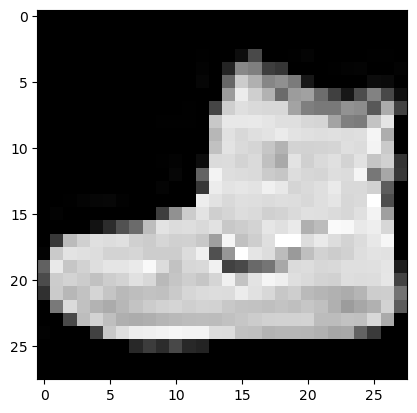

In [6]:
image = Xtrain[0] #first image in the dataset
label = ytrain[0]

print(f"Class: {label} ({labels_dict[label]})")
plt.imshow(image, cmap='gray')
plt.show()

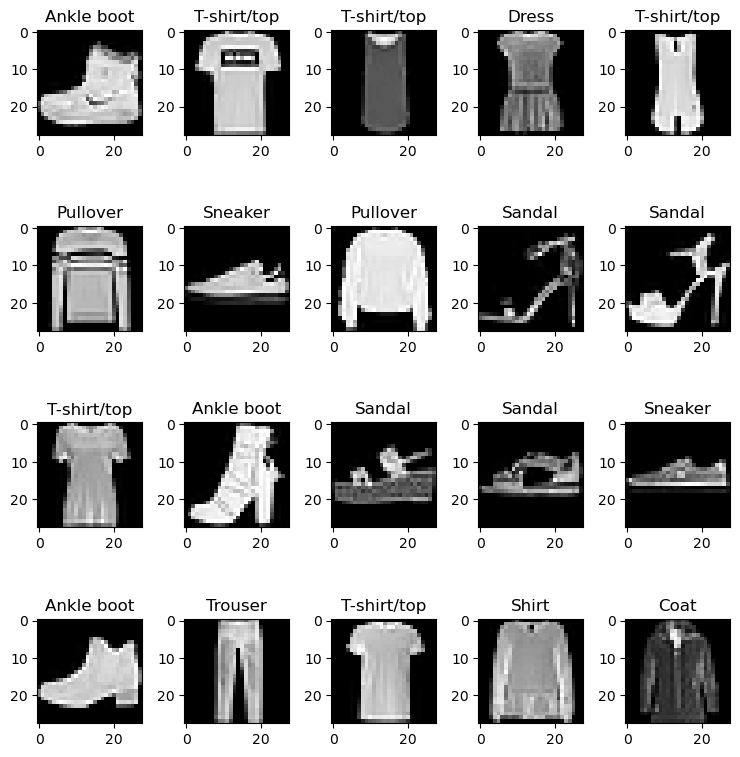

In [7]:
n_row = 4
n_col = 5

n = n_row * n_col
images = Xtrain[:n]
lab = ytrain[:n]

fig, ax = plt.subplots(n_row, n_col, figsize = (1.5*n_col, 2*n_row))
for i in range(n):
    ax_ = ax[i//n_col, i%n_col]
    ax_.imshow(images[i], cmap='gray')
    ax_.set_title(labels_dict[lab[i]])
plt.tight_layout()
plt.show()

In [8]:
#normalize it so that the values are in the [0,1] range
Xtrain = Xtrain/255
Xtest = Xtest/255

In [9]:
Xtrain = Xtrain - Xtrain.mean(axis=0)
Xtest = Xtest - Xtest.mean(axis=0)

In [10]:
# reshape the images
# this is the format in which you need your data for today

Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]))
Xtest = Xtest.reshape((Xtest.shape[0], Xtest.shape[1]*Xtest.shape[2]))

print(Xtrain.shape)
print(Xtest.shape)

(60000, 784)
(10000, 784)


The above preprocessing steps are required for all the algorithms you will be working with during this lab.

The following applies only to the autoencoder. 

In [11]:
# shaping necessary for the autoencoder

X_train = Xtrain.reshape((Xtrain.shape[0], 1, 28, 28))
X_test = Xtest.reshape((Xtest.shape[0], 1, 28, 28))

In [12]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

In [13]:
print(X_train.shape)
print(X_test.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [14]:
train_set = torch.utils.data.TensorDataset(X_train, X_train)
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set)*0.8), round(len(train_set)*0.2)])
test_set = torch.utils.data.TensorDataset(X_test, X_test)

In [15]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = False)

In [16]:
# Define the model class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # define the encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=1000),
            nn.ReLU(),
            nn.Linear(1000, 250),
            nn.ReLU(),
            nn.Linear(250, 125),
            nn.ReLU(),
            nn.Linear(125, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  
        )
        # the output of the encoder is the projection in the bottleneck (in this case, a 2-dimensional space)

        # define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 125),
            nn.ReLU(),
            nn.Linear(125, 250),
            nn.ReLU(),
            nn.Linear(250, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
        # the output of the decoder is the reconstructed image which was passed as input

    def forward(self, x):
        encoded= self.encoder(x.flatten(1)) 
        decoded = self.decoder(encoded)
        return decoded.view(-1,1,28,28), encoded

In [17]:
model = Autoencoder()

In [18]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=125, bias=True)
    (5): ReLU()
    (6): Linear(in_features=125, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=125, bias=True)
    (3): ReLU()
    (4): Linear(in_features=125, out_features=250, bias=True)
    (5): ReLU()
    (6): Linear(in_features=250, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [19]:
def train(model, train_loader, val_loader, loss_func, optimizer, num_epochs= 50):
    l_train =[]
    l_val = []

    for epoch in range(num_epochs): 
        model.train()
        loss_tr=[]

        for it, (images_raw, images_out) in enumerate(train_loader):
            optimizer.zero_grad()           
            y, _ = model(images_raw)
            loss = loss_func(images_out, y)
            loss_tr.append(loss.cpu().data.item())
            loss.backward()
            optimizer.step()
       
       #Evaluation
        model.eval()
        loss_ts = []

        with torch.no_grad():
            for it, (images_raw, images_out) in enumerate(val_loader):
                y, _ = model(images_raw)
                loss = loss_func(images_out, y)
                loss_ts.append(loss.detach().cpu().numpy())

        print(f"Epoch {epoch}, training_loss: {np.mean(loss_tr)} , validation_loss {np.mean(loss_ts)}")

        l_train.append(np.mean(loss_tr))
        l_val.append(np.mean(loss_ts))
    
    return l_train, l_val


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr = 000.1)
loss_func = torch.nn.MSELoss()

Model loaded


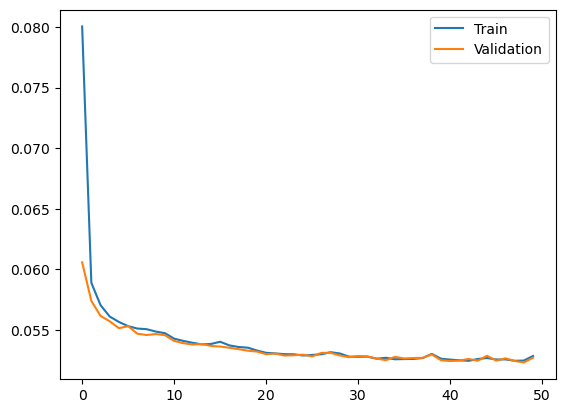

In [21]:
USE_PRETRAINED_MODEL=True

if USE_PRETRAINED_MODEL:
    model.load_state_dict(torch.load(f'Autoencoder/autoencoder_26_10_2023.pt'))
    print("Model loaded")

    display(Image('Autoencoder/Loss_autoencoder.png')) #this is the loss I have saved during the training of the autoencoder
    
else:
   l_train , l_val = train(model, train_loader, val_loader, loss_func, optimizer,  num_epochs=50) 
   #with 50 epochs it takes around 10 minutes (on the whole dataset) on my PC
   torch.save(model.state_dict(), 'Autoencoder/autoencoder.pt')
   print("Model saved")

   plt.plot(l_train, label="Train")
   plt.plot(l_val, label="Validation")
   plt.legend()
   plt.show()

In [22]:
out, encoded = model(test_set.tensors[0])

In [23]:
out = out.detach().numpy()
print(out.shape)

(10000, 1, 28, 28)


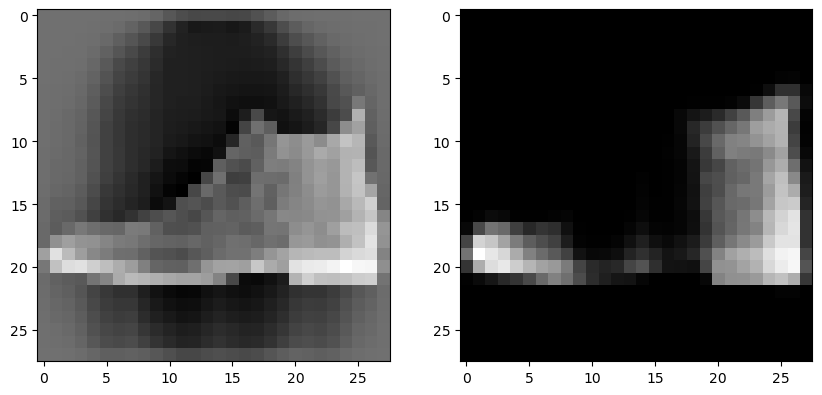

In [24]:
idx=0

image = Xtest[idx].reshape((28,28))
image_out = out[idx].reshape((28,28))

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_out, cmap='gray')
plt.show()

In [25]:
encoded = encoded.detach().numpy()
print(encoded.shape)

(10000, 2)


C:\Users\ilari\AppData\Local\Temp\ipykernel_13816\721609141.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(labels_dict.values())


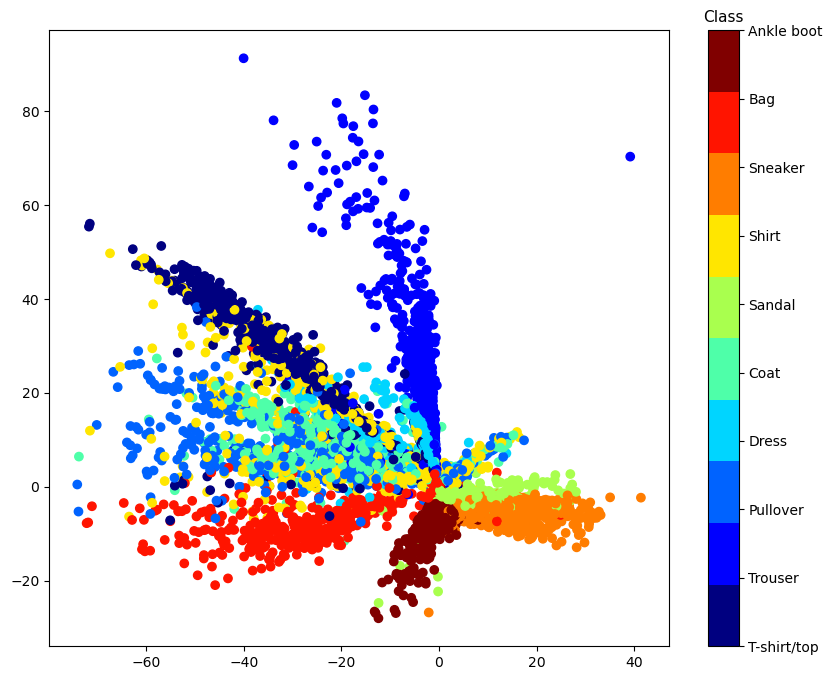

In [26]:
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('jet', 10)
p = plt.scatter(encoded[:,0], encoded[:,1], c=ytest, cmap=cmap)
cb = plt.colorbar(p)
cb.ax.set_title('Class', fontsize=11)
cb.ax.set_yticklabels(labels_dict.values())
plt.show()

C:\Users\ilari\AppData\Local\Temp\ipykernel_13816\1161514929.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(labels_dict.values())


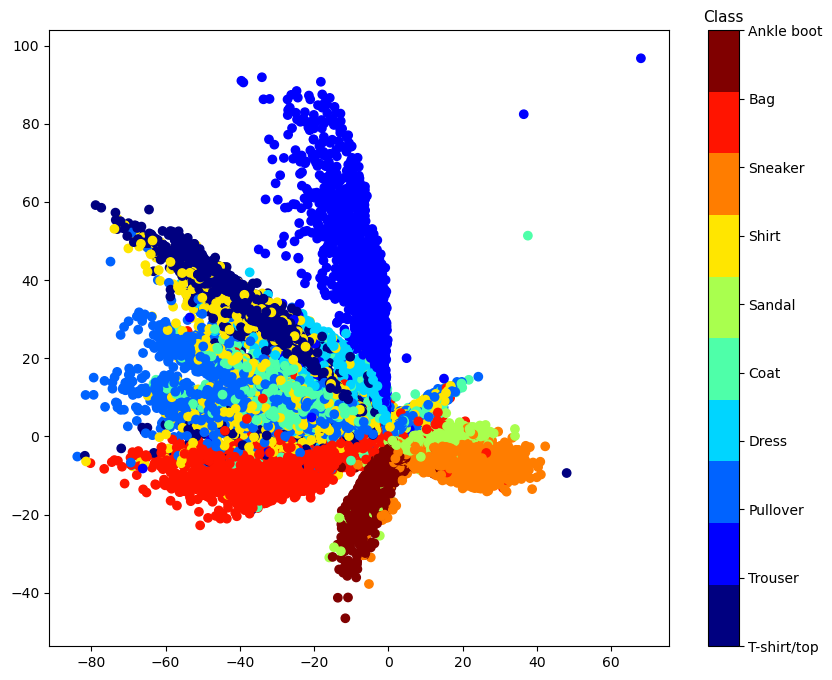

In [27]:
#on the whole trainset
_, encoded = model(train_set.dataset.tensors[0])
encoded = encoded.detach().numpy()

plt.figure(figsize=(10,8))
cmap = plt.get_cmap('jet', 10)
p = plt.scatter(encoded[:,0], encoded[:,1], c=ytrain, cmap=cmap)
cb = plt.colorbar(p)
cb.ax.set_title('Class', fontsize=11)
cb.ax.set_yticklabels(labels_dict.values())
plt.show()
plt.close()

If you are interested in Variational Autoencoders, there is a lot of documentation (and examples) online. I suggest you use the ```pytorch``` framework other than ```tensorflow``` or ```keras```. 

Since most of you have not followed a course on Deep Learning yet, we refrain from the examples with VAE but be aware of their existance and usefullness.